In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

%load_ext Cython

import sys, os
opj = os.path.join
CODE_DIR = os.path.abspath('../..')
sys.path.append(opj(CODE_DIR, 'EPypes'))
sys.path.append(opj(CODE_DIR, 'RPALib'))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import cv2
import numpy as np
import math
import multiprocessing as mp
from matplotlib import pyplot as plt
import networkx as nx
from glob import glob
import multiprocessing as mp
import concurrent.futures as cf
import nxpd

nxpd.nxpdParams['show'] = 'ipynb'
plt.gray()

In [4]:
from epypes import pipeline
from epypes import compgraph

from rpa import cbcalib
from rpa.io import open_image

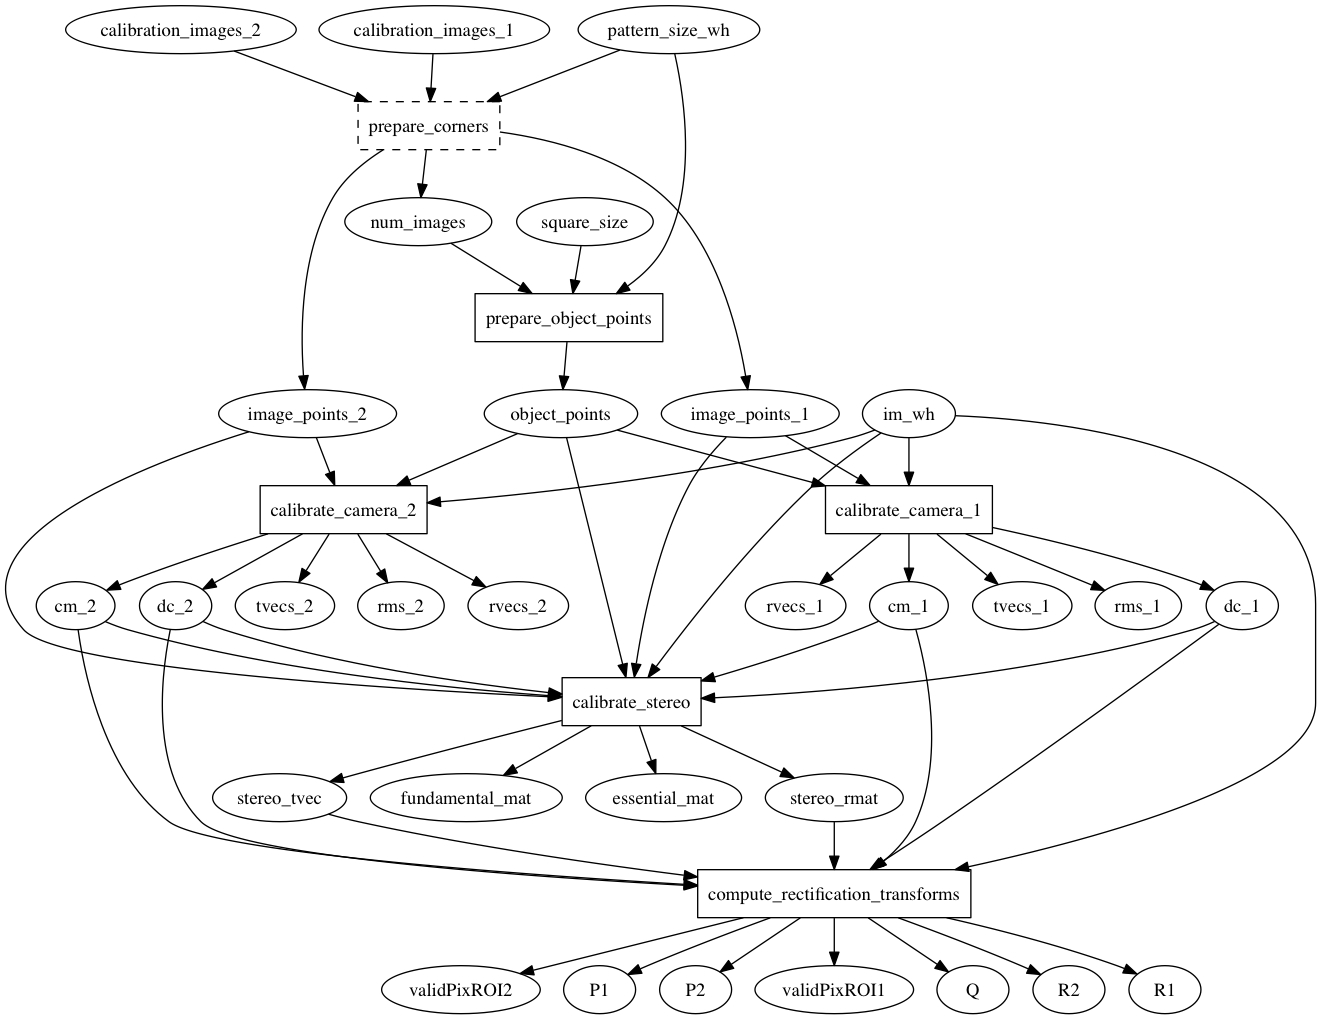

In [5]:
cg_stereocalib = cbcalib.CGCalibrateStereo()

nxpd.draw(cg_stereocalib.to_networkx())

In [6]:
cg_corners = cbcalib.CGFindCorners()

def prepare_corners_stereo(images1, images2, psize):
    
    runner1 = compgraph.CompGraphRunner(cg_corners, frozen_tokens={'pattern_size_wh': psize})
    runner2 = compgraph.CompGraphRunner(cg_corners, frozen_tokens={'pattern_size_wh': psize})
    
    res1 = []
    res2 = []
    num_images = 0
    for im1, im2 in zip(images1, images2):
        
        runner1.run(image=im1)
        runner2.run(image=im2)
        
        both_ok = runner1['success'] and runner2['success']

        if both_ok:
            res1.append(runner1['corners_np'])
            res2.append(runner2['corners_np'])
            num_images += 1
        
    return res1, res2, num_images

In [7]:
images1 = [open_image(f) for f in glob(opj(CODE_DIR, 'DATA/IMG/calib/opencv_left/*.jpg'))]
images2 = [open_image(f) for f in glob(opj(CODE_DIR, 'DATA/IMG/calib/opencv_right/*.jpg'))]
psize = (9, 6)
sq_size = 10.

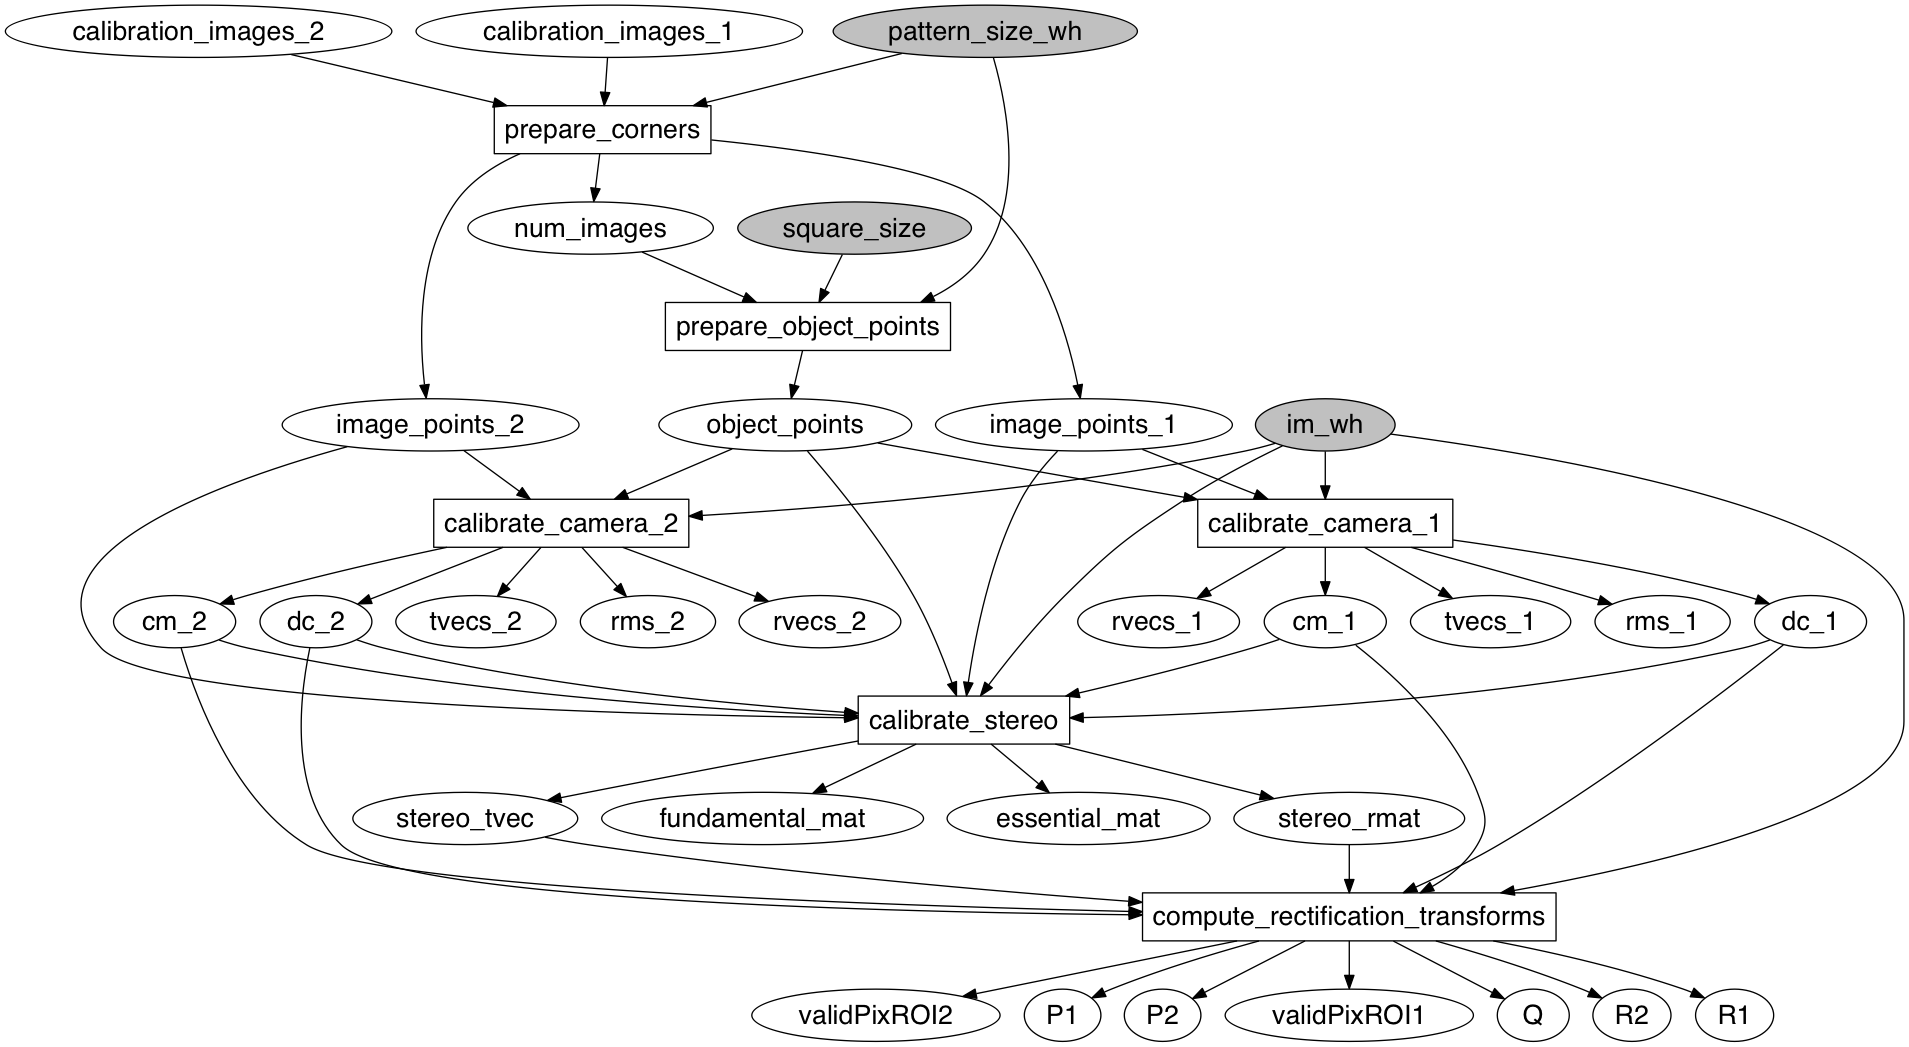

In [54]:
cg_stereocalib.swap_function('prepare_corners', prepare_corners_stereo)

params = {
    'im_wh': cbcalib.get_im_wh(images1[0]),
    'pattern_size_wh': psize,
    'square_size': sq_size   
}

pipe = pipeline.Pipeline('StereoCalibSerial', cg_stereocalib, frozen_tokens=params)

nxg = pipe.runner.token_manager.to_networkx()
for node_name in nxg.nodes_iter():
    nxg.node[node_name]['fontname'] = 'Helvetica' # 'Helvetica bold' may be better for embedding in the paper
    nxg.node[node_name]['fontsize'] = 20

nxpd.draw(nxg)

In [9]:
pipe.run(calibration_images_1=images1, calibration_images_2=images2)

In [10]:
print('Number of calibration images opened: ', len(pipe['calibration_images_1']))
print('Number of images with good corners', len(pipe['image_points_1']))

Number of calibration images opened:  13
Number of images with good corners 13


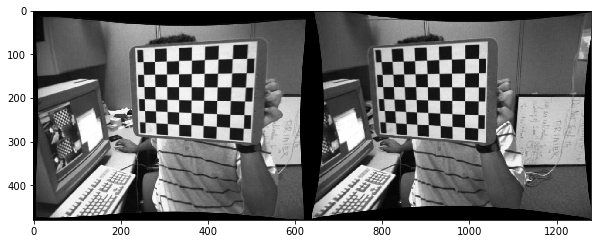

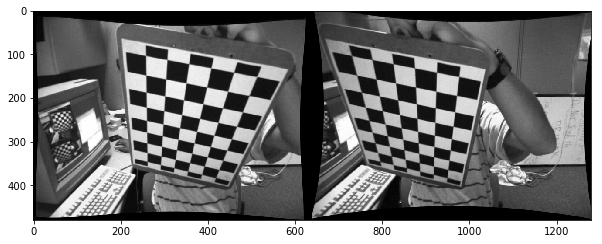

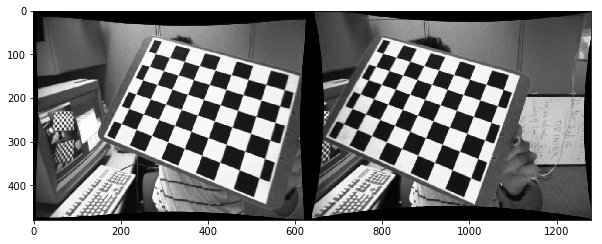

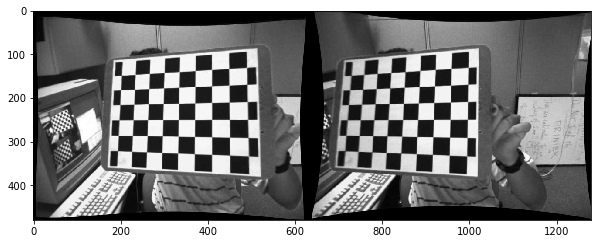

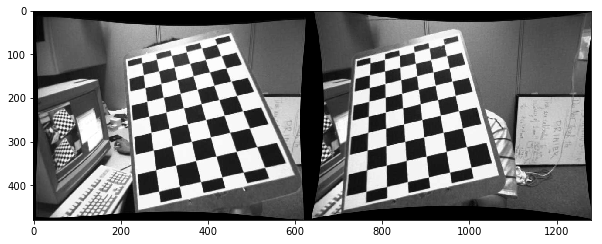

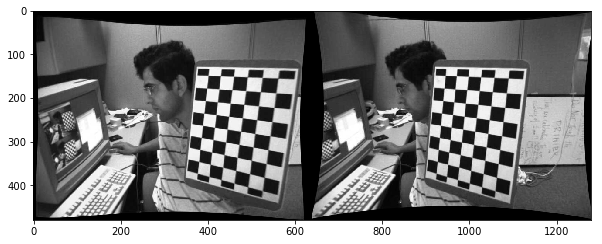

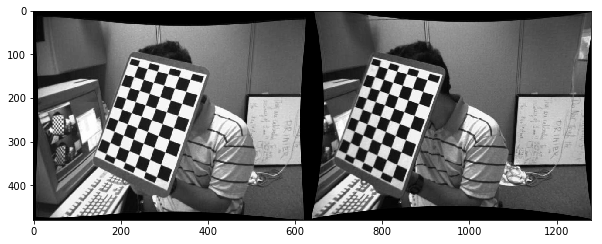

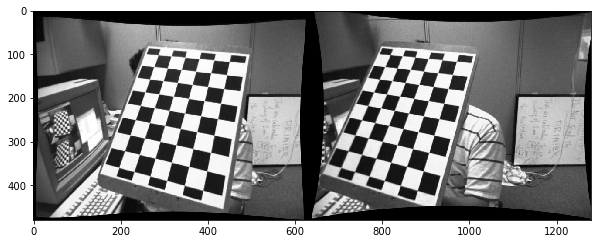

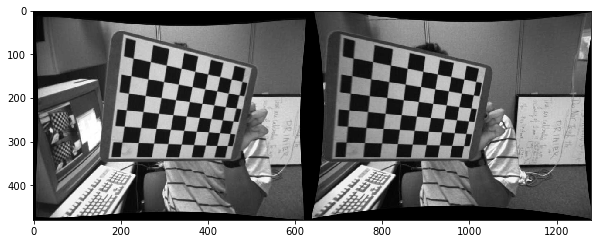

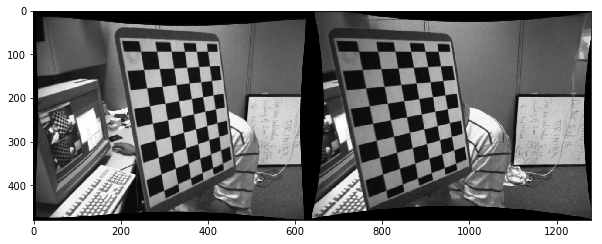

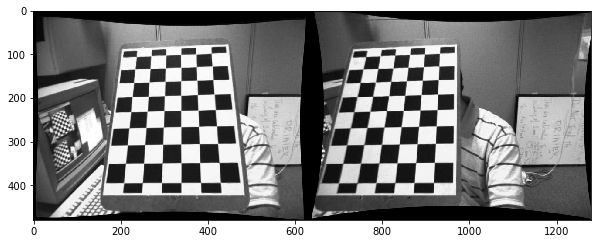

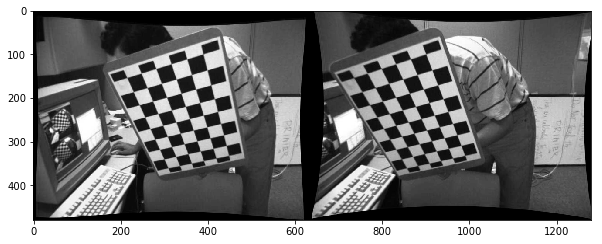

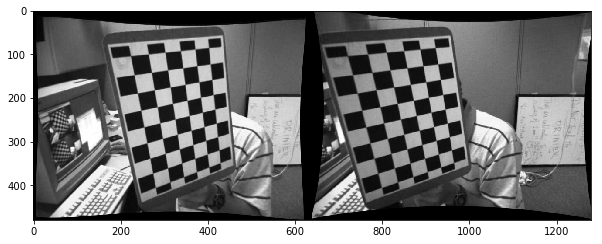

In [11]:
images1_rect, images2_rect, maps1, maps2 = cbcalib.undistort_and_rectify_images_stereo(
    images1,
    images2,
    pipe['cm_1'],
    pipe['dc_1'],
    pipe['cm_2'],
    pipe['dc_2'],
    pipe['R1'],
    pipe['R2'],
    pipe['P1'],
    pipe['P2']
)

for i in range(len(images1_rect)):
    plt.figure(figsize=(10, 20))
    plt.imshow(np.hstack((images1_rect[i], images2_rect[i])))

As you can see from the printout of `traverse_time`, the `prepare_object_points` is the major bottleneck.

In [19]:
pipe.run(calibration_images_1=images1, calibration_images_2=images2)
pipe.traverse_time()

('StereoCalibSerial',
 0.571159839630127,
 (('prepare_corners', 0.4144749641418457),
  ('prepare_object_points', 0.0003199577331542969),
  ('calibrate_camera_1', 0.05975818634033203),
  ('calibrate_camera_2', 0.07637667655944824),
  ('calibrate_stereo', 0.01982712745666504),
  ('compute_rectification_transforms', 6.008148193359375e-05)))

The following test recreates the logic of `prepare_object_points`, but without saving results to lists. As you can see, execution time is still very high (loops in Python are to blame). 

In [13]:
cb_runner1 = compgraph.CompGraphRunner(cg_corners, frozen_tokens={'pattern_size_wh': psize})
cb_runner2 = compgraph.CompGraphRunner(cg_corners, frozen_tokens={'pattern_size_wh': psize})

def test_corners_runtime():
    
    for im1, im2 in zip(images1, images2):
        
        cb_runner1.run(image=im1)
        cb_runner2.run(image=im2)

In [16]:
%timeit test_corners_runtime()

339 ms ± 28.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Comparing the previous measurements with 26 x CornerDetector's runtime with one image

In [55]:
cb_test_pipeline = pipeline.Pipeline('CornerDetector', cg_corners, frozen_tokens={'pattern_size_wh': psize})

cb_test_pipeline.run(image=images1[0])
print('For a single image:', cb_test_pipeline.traverse_time()[:2])
print('(Theoretically) for 26 images:', cb_test_pipeline.traverse_time()[1] * 26)

For a single image: ('CornerDetector', 0.0035130977630615234)
(Theoretically) for 26 images: 0.09134054183959961
